In [1]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
import time
import math
from paq2py import *
from parse_markpoints import ParseMarkpoints
from utils import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

%matplotlib inline

In [2]:
paq_path = r'/media/jamesrowland/DATA/plab/s2_100_shots/2019-03-12_RL025_t_007.paq'
s2p_path = r'/media/jamesrowland/DATA/plab/s2_100_shots/artifactRemoved/suite2p'
naparm_path = r'/media/jamesrowland/DATA/plab/s2_100_shots/2019-03-12_RL025_NAPARM_006'
csv_path = '/media/jamesrowland/DATA/plab/s2_100_shots/sigCellRaw.csv'

In [3]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=True)
arr = dfof(raw)
num_units = arr.shape[0]

arr.shape

# raw = read_fiji(csv_path)
# #help with enumeration
# arr = np.vstack([raw]*3)
# num_units = 264
# arr = dfof(arr)
# arr = np.squeeze(arr)
# arr.shape

(264, 30770)

In [4]:
xml_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.xml'))
gpl_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.gpl'))

In [5]:
clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

#digitise frame clock, two clocks should not occur less than 10ms apart or more than 100ms apart
frame_clock = digitise_trigger(clock_voltage, min_time = 0.01*paq['rate'], max_time = 0.1*paq['rate'])


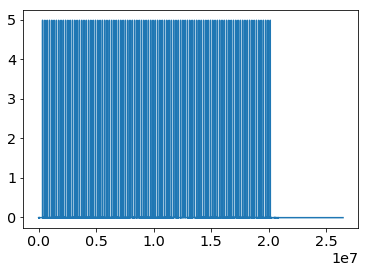

100

In [6]:
m2p_idx = paq['chan_names'].index('markpoints2packio')
m2p_volts = paq['data'][m2p_idx, :]

#stims should not occur within 1ms of each other
stim_times = digitise_trigger(m2p_volts, min_time = 0.001*paq['rate'])

markpoints = ParseMarkpoints(xml_path=xml_path, gpl_path=gpl_path)
assert len(stim_times) == int(markpoints.iterations)

plt.figure()
plt.plot(m2p_volts)
plt.show()
len(stim_times)

In [7]:
# assume all group durations the same
single_duration = float(markpoints.durations[0]) #ms
repetitions = float(markpoints.repetitions[0])
n_groups = len(markpoints.durations)
duration_ms = single_duration * repetitions * n_groups

#correct this based on txt file
duration_ms = 1200

duration_samples = (duration_ms / 1000) * paq['rate']

single_duration
n_groups

60

In [8]:
#use this to remove frames during stim based on paq
to_remove = []

for stim in stim_times:

    #the sample time of the frame immediately preceeding stim
    stim_start_frame = next(frame_clock[i-1] for i,sample in enumerate(frame_clock) if sample - stim > 0)

    # frame indexes that fall during the stim
    in_stim = np.where((frame_clock >= stim_start_frame) & (frame_clock <= stim + duration_samples))[0]
    
    in_stim = np.append(in_stim, in_stim[-1] + 1)
    in_stim = np.append(in_stim, in_stim[-1] + 1)
    
    [to_remove.append(f) for f in in_stim]
    
arr[:, to_remove] = np.nan


In [9]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim > 0)
    
    stim_start_frames.append(stim_start_frame)
    
assert len(stim_start_frames) == int(markpoints.iterations)

stim_start_frames = np.array(stim_start_frames)
#assert max(stim_start_frames) < arr.shape[1]


In [10]:
pre_frames = 50
post_frames = 100

all_trials = []
stas = []
dfs = []
t_tests = []
mann_whits = []

count = 0
    
for i, unit in enumerate(arr):

    trials = []
    df = []
    
    # observations before stim
    pre_obs = []
    #observations after stim
    post_obs = []

    for stim in stim_start_frames:
        
        pre_stim  = unit[stim-pre_frames: stim]
        post_stim = unit[stim: stim + post_frames]
        
        pre_mean = np.mean(pre_stim)
        post_mean = np.mean(post_stim)
        df.append(post_mean - pre_mean)

        [pre_obs.append(ob) for ob in pre_stim]
        [post_obs.append(ob) for ob in post_stim]
                          
        trial = unit[stim-pre_frames : stim+post_frames]
        trials.append(trial)
  
    trials = np.array(trials)
    all_trials.append(trials)

    sta = np.mean(trials, 0)        
    stas.append(sta)
    
    dfs.append(np.mean(df))
    pre_obs = [x for x in pre_obs if ~np.isnan(x)]
    post_obs = [x for x in post_obs if ~np.isnan(x)]
    
    t_test = stats.ttest_ind(pre_obs, post_obs)
    mann_whit = stats.mannwhitneyu(pre_obs, post_obs)
    
    t_tests.append(t_test)
    mann_whits.append(mann_whit)
    
        
    if t_test[1] < 0.05 / num_units:
        count += 1
        
 
dfs = np.array(dfs)
stas = np.array(stas)
all_trials = np.array(all_trials)




In [11]:
p_vals = [t[1] for t in mann_whits]
idx = range(len(p_vals))

for p,i in sorted(zip(p_vals,idx)):
    if p < 0.05 / num_units:
        print('unit {} has P value of {}'.format(i, p))


unit 40 has P value of 0.0
unit 246 has P value of 1.7237123315704051e-128
unit 96 has P value of 3.7070368953949076e-111
unit 35 has P value of 2.9987816532541416e-92
unit 68 has P value of 2.4403389777731965e-82
unit 6 has P value of 2.1028797192005147e-81
unit 109 has P value of 3.3956869550781513e-79
unit 61 has P value of 4.192352355316712e-63
unit 82 has P value of 2.1248469338683382e-58
unit 28 has P value of 1.6580636696740711e-56
unit 15 has P value of 2.043890800935155e-56
unit 44 has P value of 1.7097910837327393e-55
unit 182 has P value of 5.4356624120682335e-55
unit 1 has P value of 6.958613979443942e-54
unit 2 has P value of 1.4007923592493867e-52
unit 151 has P value of 1.3829519758387617e-49
unit 14 has P value of 8.150998547194544e-49
unit 171 has P value of 1.6245787906456293e-48
unit 27 has P value of 1.021086522301701e-45
unit 91 has P value of 1.4342654150550677e-45
unit 9 has P value of 4.447629546269151e-45
unit 55 has P value of 1.5634002127033623e-44
unit 59 ha

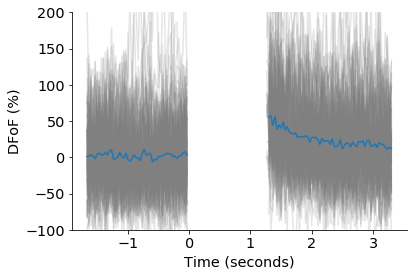

In [12]:
unit = 96

frame_rate = 30
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

plt.figure()

sta = stas[unit]
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
plt.plot(x_axis, sta)
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF (%)')
plt.ylim((-100,200))
#plt.plot([pre_frames] * 100, np.linspace(min(sta), max(sta), 100), '--')
sns.despine()
plt.savefig('s2_responsive_cell.pdf')

In [14]:
stat[96]

{'aspect_ratio': 1.0627851161944484,
 'compact': 1.0145813932145569,
 'footprint': 0.7707544319411221,
 'ipix_neuropil': (array([154338, 154339, 154340, 154341, 154849, 154850, 154851, 154852,
         154853, 154854, 155360, 155361, 155362, 155363, 155364, 155365,
         155366, 155367, 155870, 155871, 155872, 155873, 155874, 155875,
         155876, 155877, 155878, 156381, 156382, 156383, 156384, 156385,
         156386, 156387, 156892, 156893, 156894, 156895, 156896, 156897,
         156898, 156899, 156900, 157403, 157404, 157405, 157406, 157407,
         157408, 157409, 157410, 157411, 157412, 157915, 157916, 157917,
         157918, 157919, 157920, 157921, 157922, 157923, 157924, 158427,
         158428, 158429, 158430, 158431, 158432, 158433, 158434, 158435,
         158939, 158940, 158941, 158942, 158943, 158944, 158945, 158946,
         158947, 158958, 159452, 159453, 159454, 159455, 159456, 159457,
         159470, 159471, 159964, 159965, 159966, 159967, 159968, 159981,
    

In [13]:
1/0

ZeroDivisionError: division by zero

In [ ]:
unit = 40
frame_rate = 30
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

plt.figure(figsize=(7,7))
sta = stas[unit]
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
plt.plot(x_axis, sta)
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF (%)')
#plt.plot([pre_frames] * 100, np.linspace(min(sta), max(sta), 100), '--')
sns.despine()
plt.savefig('s2_responsive_cell.pdf')


In [ ]:
for i,s in enumerate(stat):
    if s['original_index'] == 126:
        print(i)
        print(p_vals[i])